In [1]:
import src.utils.utilities as utilities
import src.utils.models as models
from api import Api
mlApi = Api()

Using TensorFlow backend.


In [3]:
# define dataset specifics
filename = "../HX-condition-monitoring/datasets/D/data.csv"

columns = [
    ['20TT001', 'Gas side inlet temperature', 'degrees'],
    ['20PT001', 'Gas side inlet pressure', 'barG'],
    ['20FT001', 'Gas side flow', 'M^3/s'],
    ['20TT002', 'Gas side outlet temperature', 'degrees'],
    ['20PDT001', 'Gas side pressure difference', 'bar'],
    ['50TT001', 'Cooling side inlet temperature', 'degrees'],
    ['50PT001', 'Cooling side inlet pressure', 'barG'],
    ['50FT001', 'Cooling side flow', 'M^3/s'],
    ['50TT002', 'Cooling side outlet temperature', 'degrees'],
    ['50PDT001', 'Cooling side pressure differential', 'bar'],
    ['50TV001', 'Cooling side valve opening', '%'],
]

irrelevantColumns = [
    '50FT001',
    '50PDT001',
    '20PDT001',
    '50TV001',
]

targetColumns = [
    '50TT002',
]

In [4]:
traintime = [
        ["2020-01-01 00:00:00", "2020-02-01 00:00:00"],
    ]

testtime = [
    "2020-01-01 00:00:00",
    "2020-07-01 00:00:00"
]

In [6]:
args = utilities.Args({
    'activation': 'relu',
    'loss': 'mean_squared_error',
    'optimizer': 'adam',
    'metrics': ['mean_squared_error'],
    'epochs': 50,
    'batchSize': 32,
    'verbose': 0,
    'callbacks': utilities.getBasicCallbacks(),
    'enrolWindow': 16,
    'validationSize': 0.2,
    'testSize': 0.2,
})

lstmArgs = utilities.Args({
    'activation': 'relu',
    'loss': 'mean_squared_error',
    'optimizer': 'adam',
    'metrics': ['mean_squared_error'],
    'epochs': 50,
    'batchSize': 32,
    'verbose': 0,
    'callbacks': utilities.getBasicCallbacks(monitor="loss"),
    'enrolWindow': 1,
    'validationSize': 0.2,
    'testSize': 0.2
})

lstmArgs2 = utilities.Args({
    'activation': 'relu',
    'loss': 'mean_squared_error',
    'optimizer': 'adam',
    'metrics': ['mean_squared_error'],
    'epochs': 50,
    'batchSize': 32,
    'verbose': 0,
    'callbacks': utilities.getBasicCallbacks(monitor="loss"),
    'enrolWindow': 16,
    'validationSize': 0.2,
    'testSize': 0.2
})

In [7]:
names = list(map(lambda el: el[0], columns))
descriptions = list(map(lambda el: el[1], columns))
units = list(map(lambda el: el[2], columns))

relevantColumns = list(filter(lambda col: col not in irrelevantColumns, map(lambda el: el[0], columns)))
columnUnits = dict(zip(names, units))
columnDescriptions = dict(zip(names, descriptions))

df = mlApi.initDataframe(filename, relevantColumns, columnDescriptions)
df_train, df_test = mlApi.getTestTrainSplit(traintime, testtime)
X_train, y_train, X_test, y_test = mlApi.getFeatureTargetSplit(targetColumns)

Date index set
Columns before removal
-------------------------------------------
Dataset columns:
Col. 0 : Index
Col. 1 : 20TT001 - Gas side inlet temperature
Col. 2 : 20PT001 - Gas side inlet pressure
Col. 3 : 20FT001 - Gas side flow
Col. 4 : 20TT002 - Gas side outlet temperature
Col. 5 : 20PDT001 - Gas side pressure difference
Col. 6 : 50TT001 - Cooling side inlet temperature
Col. 7 : 50PT001 - Cooling side inlet pressure
Col. 8 : 50FT001 - Cooling side flow
Col. 9 : 50TT002 - Cooling side outlet temperature
Col. 10 : 50PDT001 - Cooling side pressure differential
Col. 11 : 50TV001 - Cooling side valve opening
-------------------------------------------
Columns after removal
-------------------------------------------
Dataset columns:
Col. 0 : 20TT001 - Gas side inlet temperature
Col. 1 : 20PT001 - Gas side inlet pressure
Col. 2 : 20FT001 - Gas side flow
Col. 3 : 20TT002 - Gas side outlet temperature
Col. 4 : 50TT001 - Cooling side inlet temperature
Col. 5 : 50PT001 - Cooling side in

In [8]:
keras_seq_mod_regl = models.kerasSequentialRegressionModelWithRegularization(
    params={
        'name': '50 20 regularized',
        'X_train': X_train,
        'y_train': y_train,
        'args': args,
    },
    structure=[
        [50, args.activation],
        [20, args.activation]
    ],
)
keras_seq_mod_simple = models.kerasSequentialRegressionModel(
    params={
        'name': '20 normal',
        'X_train': X_train,
        'y_train': y_train,
        'args': args,
    },
    structure=[
        [20, args.activation]
    ],
)
keras_seq_mod_v_simple = models.kerasSequentialRegressionModel(
    params={
        'name': '0 Simple',
        'X_train': X_train,
        'y_train': y_train,
        'args': args,
    },
    structure=[
        [X_train.shape[1], args.activation]
    ], 
)
keras_seq_mod = models.kerasSequentialRegressionModel(
    params={
        'name': '50 20 normal',
        'X_train': X_train,
        'y_train': y_train,
        'args': args,
    },
    structure=[
        [50, args.activation],
        [20, args.activation]
    ]
)
lstmModel = models.kerasLSTMSingleLayerLeaky(
    params={
        'name': 'LSTM 128',
        'X_train': X_train,
        'y_train': y_train,
        'args': lstmArgs,
    },
    units=128,
    dropout=0.1,
    alpha=0.5
)
lstmModel2 = models.kerasLSTMSingleLayerLeaky(
    params={
        'name': 'LSTM 2 128',
        'X_train': X_train,
        'y_train': y_train,
        'args': lstmArgs2,
    },
    units=128,
    dropout=0.1,
    alpha=0.5
)
sklearnLinearModel = models.sklearnRidgeCV(
    params={
        'name': 'Linear',
        'X_train': X_train,
        'y_train': y_train,
    },
) 
ensemble = models.ensembleModel(
    params={
        'name': 'ensemble 4 mods',
        'X_train': X_train,
        'y_train': y_train,
    },
    models=[
        keras_seq_mod_regl,
        keras_seq_mod_simple,
        lstmModel,
        sklearnLinearModel,
    ],
)

Training model 50 20 normal
Training model 20 normal
Training model ensemble 4 mods
Training model LSTM 128
Training model Linear


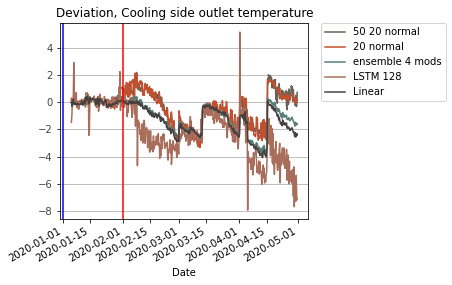

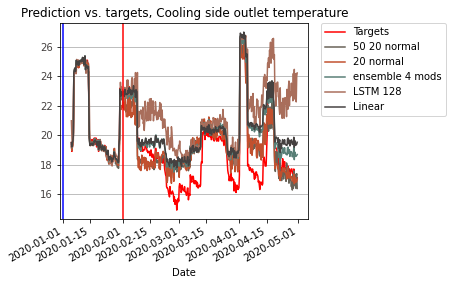

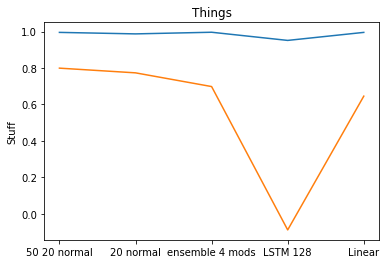

In [11]:
modelList = [
    keras_seq_mod,
    keras_seq_mod_simple,
    ensemble,
    lstmModel,
    sklearnLinearModel,
]

mlApi.initModels(modelList)
retrain=True
mlApi.trainModels(retrain)
modelNames, metrics_train, metrics_test = mlApi.predictWithModels(plot=True)